### Imports

In [1]:
import sys
import os
import copy
sys.path.append(os.path.abspath('../'))

import random
from datetime import datetime

from environment.evaluation import *
from environment.data_loader import *

import itertools

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

### Config

In [2]:
colors = {
    "DQN": 'darkorange',
    "REINFORCE": 'forestgreen',
    "ODT": 'blueviolet',
}

season_colors = {
    "winter": 'blue',
    "spring": 'forestgreen',
    "summer": 'gold',
    "autumn": 'darkorange'
}

exp_lists_preformatted = [
    '4000_4017.csv', '4018_4035.csv', '5000_5017.csv', '5018_5035.csv', '6000_6017.csv', '6018_6035.csv', # DQN
    '4036_4053.csv', '4054_4071.csv', '5036_5053.csv', '5054_5071.csv', '6036_6053.csv', '6054_6071.csv', # REINFORCE
    '4108_4125.csv', '4126_4143.csv', '5108_5125.csv', '5126_5143.csv', '6108_6125.csv', '6126_6143.csv', # ODT 1
    '4144_4161.csv', '4162_4179.csv', '5144_5161.csv', '5162_5179.csv', '6144_6161.csv', '6162_6179.csv' # ODT 2
] # Existing formatted datasets

## Figure 2

### Loading data

In [4]:
# Define the file path with starting_exp and ending_exp variables
file_path_for_processed_data = f'../../../../storage_1/metrics/formatted_experiment_data/part_1/'

if len(exp_lists_preformatted) > 0:
    dataframes = []
    
    # Load and combine datasets
    for existing_set in exp_lists_preformatted:
        loaded_dataset = pd.read_csv(f"{file_path_for_processed_data}/{existing_set}")
        # Combine datasets
        dataframes.append(loaded_dataset)

    cumulative_avg_reward_by_algorithm = pd.concat(dataframes, ignore_index=True)

cumulative_avg_reward_by_algorithm['num_aggs'] = np.where(
    (cumulative_avg_reward_by_algorithm['num_aggs'] == 3) & 
    (cumulative_avg_reward_by_algorithm['algorithm'].isin(['CMA', 'DENSER'])), 
    1, 
    cumulative_avg_reward_by_algorithm['num_aggs']
)

### Displaying figure

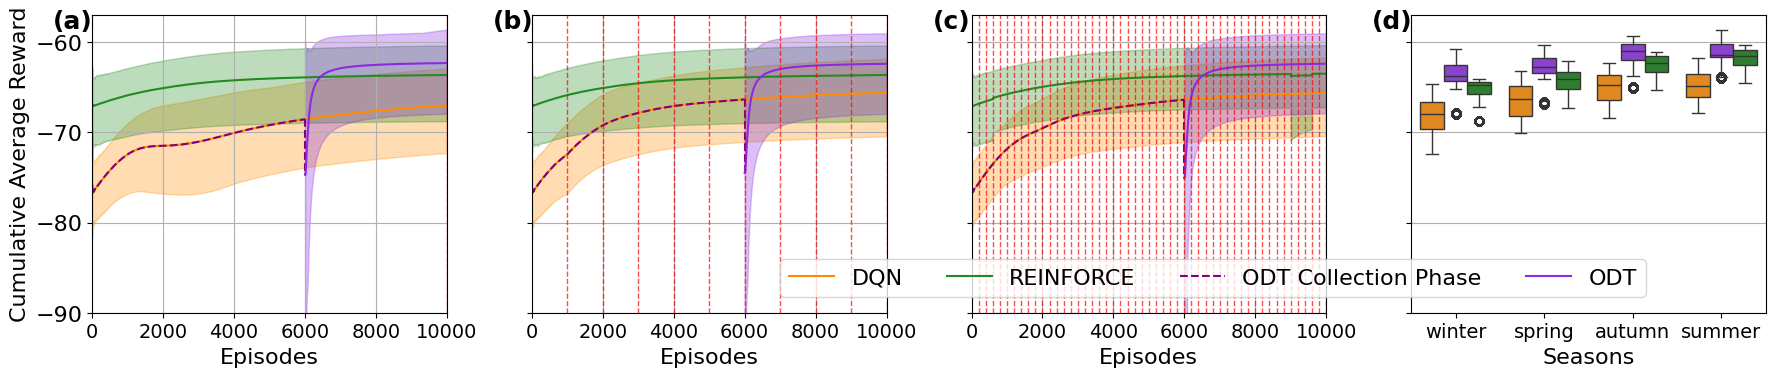

In [10]:
avg_reward_by_algorithm =  copy.deepcopy(cumulative_avg_reward_by_algorithm)

# Initialize lists to store legend handles and labels
algorithm_handles = []
algorithm_labels = []
algorithms_added = set()

season_handles = []
season_labels = []
seasons_added = set()

# Begin plotting
agg_levels_sorted = sorted(avg_reward_by_algorithm['num_aggs'].unique(), reverse=False)
num_plots = len(agg_levels_sorted)+1

#experiment with 16 --> 20 etc...
fig, axes = plt.subplots(1, num_plots, figsize=(18, 4), sharey=True, sharex=False)

# Set global font size
plt.rcParams.update({
    'font.size': 14,             # Base font size
    'axes.titlesize': 16,        # Font size for axes titles
    'axes.labelsize': 16,        # Font size for x and y labels
    'xtick.labelsize': 14,       # Font size for x-axis ticks
    'ytick.labelsize': 16,       # Font size for y-axis ticks
    'legend.fontsize': 16,       # Font size for legend text
    'figure.titlesize': 18       # Font size for figure titles
})

axes = np.atleast_1d(axes)

subplot_labels = ['(a)', '(b)', '(c)', '(d)']
def subplots_visual(ax, plot_ind):
    ax.text(
    -0.11, 1.02,
    subplot_labels[plot_ind],
    transform=ax.transAxes,
    fontsize=18,
    fontweight='bold',
    va='top',
    ha='left')

# shift ODT episodes by the same amount
ep_shift = 6000
mask = avg_reward_by_algorithm['algorithm'] == 'ODT'
avg_reward_by_algorithm.loc[mask, 'episode'] += ep_shift

for plot_ind, agg_level in enumerate(agg_levels_sorted):
    ax = axes[plot_ind]

    subplots_visual(ax, plot_ind)

    # select this aggregation level
    agg = avg_reward_by_algorithm[
        avg_reward_by_algorithm['num_aggs'] == agg_level
    ].copy()

    # --- pre-compute and plot DQN + bridge up to ep_shift ---
    dqn = agg[agg['algorithm'] == 'DQN']
    if not dqn.empty:
        dqn_min  = dqn.groupby('episode')['cumulative_reward'].min()
        dqn_max  = dqn.groupby('episode')['cumulative_reward'].max()
        dqn_mean = dqn.groupby('episode')['cumulative_reward'].mean()

        # filled + solid DQN
        ax.fill_between(
            dqn_min.index, dqn_min.values, dqn_max.values,
            color=colors['DQN'], alpha=0.3
        )
        solid_line, = ax.plot(
            dqn_mean.index, dqn_mean.values,
            color=colors['DQN']
        )

        # dashed bridge to ep_shift
        bridge = dqn_mean[dqn_mean.index <= ep_shift]
        dashed_line, = ax.plot(
            bridge.index, bridge.values,
            linestyle='--', color='purple'
        )

        # legend entries once
        if 'dqn2odt' not in algorithms_added:
            algorithm_handles.extend([solid_line, dashed_line])
            algorithm_labels.extend(['DQN', 'ODT Collection Phase'])
            algorithms_added.update(['DQN', 'dqn2odt'])



    # draw a connector from end of DQN bridge to start of ODT
    odt = agg[agg['algorithm'] == 'ODT']
    if not odt.empty:
        odt_mean     = odt.groupby('episode')['cumulative_reward'].mean()
        odt_start_ep = odt_mean.index.min()
        odt_start_val= odt_mean.loc[odt_start_ep]
        y0 = dqn_mean.loc[ep_shift]
        y1 = odt_start_val

        ax.plot(
            [ep_shift,    odt_start_ep],
            [y0,          y1],
            linestyle='--', color='purple'
        )

    # re-calc for vertical lines
    total_eps = agg['episode'].max()
    eps_per_agg = np.ceil(total_eps / agg_level)

    # plot all other algorithms
    for algo in agg['algorithm'].unique():
        if algo == 'DQN' or algo == 'CMA':
            continue

        algo_data = agg[agg['algorithm'] == algo]
        min_r = algo_data.groupby('episode')['cumulative_reward'].min()
        max_r = algo_data.groupby('episode')['cumulative_reward'].max()
        mean_r= algo_data.groupby('episode')['cumulative_reward'].mean()

        ax.fill_between(
            min_r.index, min_r.values, max_r.values,
            color=colors[algo], alpha=0.3
        )
        line, = ax.plot(
            mean_r.index, mean_r.values,
            color=colors[algo]
        )

        name = 'CMA-ES' if algo == 'CMA' else algo
        if algo not in algorithms_added:
            algorithm_handles.append(line)
            algorithm_labels.append(f'{name}')
            algorithms_added.add(algo)

    # aggregation boundary lines
    for agg_i in range(1, agg_level + 1):
        ax.axvline(
            x=(agg_i * eps_per_agg),
            color='r', linestyle='--', linewidth=1, alpha=0.7
        )

    ax.set_xlabel('Episodes')
    ax.grid(True)
    ax.set_xlim(0, 10000)


# shared y-label
axes[0].set_ylabel('Cumulative Average Reward')
axes[0].set_ylim(-90,-57)


# Seasonality sublplot on last k elements for all aggreations 
range_bot = 9800
mask = (avg_reward_by_algorithm.episode > range_bot)
last_k = avg_reward_by_algorithm.loc[mask]
# Custom order
season_order = ['winter', 'spring', 'autumn', 'summer']
# algorithm_order = ['CMA', 'DQN', 'ODT', 'REINFORCE']
algorithm_order = ['DQN', 'ODT', 'REINFORCE']


# Draw a nested boxplot to show bills by day and time
ax = axes[3]
sns.boxplot(data=last_k, x="season", y="cumulative_reward",
            hue="algorithm", order=season_order, ax=ax,
           hue_order=algorithm_order, palette=colors)
# Setting season subplot visuals
ax.legend_.remove()
ax.set_xlabel('Seasons')
ax.yaxis.grid(True)
subplots_visual(ax, 3)



# Build a map from label → handle
handle_map = dict(zip(algorithm_labels, algorithm_handles))

# Define your desired order by label
# desired = ['DQN', 'REINFORCE', 'CMA-ES', 'ODT Collection Phase', 'ODT']
desired = ['DQN', 'REINFORCE', 'ODT Collection Phase', 'ODT']


# Re-assemble handles & labels in that order
handles = [handle_map[label] for label in desired]
labels  = desired

# Draw the legend
fig.legend(handles, labels,
           loc='lower center',
           ncol=len(handles),
           bbox_to_anchor=(0.68, 0.2))


fig.tight_layout(rect=[0, 0, 1, 1])
fig.savefig('./figures/episode_plateau_and_seasons.png', dpi=300, bbox_inches='tight')
plt.show()


## Figure 3

### Loading data

In [ ]:
experiments = list(itertools.chain(
    range(4000, 4180),
    range(5000, 5180),
    range(6000, 6180),
))
target_agg_count = 10

exp_power_data = []

for ind, exp_num in enumerate(experiments):
    config_fname = f'../experiments/Exp_{exp_num}/config.yaml'
    
    c = load_config_file(config_fname)
    nn_c = c['nn_hyperparameters']
    federated_c = c['federated_learning_settings']
    algo_c = c['algorithm_settings']

    if algo_c == 'ODT':
        target_agg_count = 4
    
    env_c = c['environment_settings']
    eval_c = c['eval_config']
    
    ev_info = []

    seed = env_c['seed']

    algorithm_dm = algo_c['algorithm']
    
    def load_from_json_with_error_handling(filepath, columns_specific):
        try:
            return read_csv_data(filepath, columns=columns_specific)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
            return None  # Handle the error and return None or an empty object
    
    
    d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
    
    if not os.path.exists(d_base):
        d_base = f"../metrics/Exp_{exp_num}"
            
    base_path = f"{d_base}/train/"

    print(f'Loading {base_path}power_and_co2_metrics.csv')
    power_data = load_from_json_with_error_handling(f'{base_path}power_and_co2_metrics.csv', ['time', 'power', 'co2'])

    power_data['seed'] = seed
    power_data['exp_num'] = exp_num
    
    power_data['algorithm'] = algorithm_dm
    power_data['season'] = env_c['season']
    power_data['num_aggs'] = federated_c['aggregation_count']
    power_data['eps_per_agg'] = nn_c['num_episodes']

    exp_power_data.append(power_data)

# Convert data to DataFrame for easier manipulation
df_power = pd.concat(exp_power_data, ignore_index=True)

# REMOVE CMA temp
df_power = df_power[df_power['algorithm'] != 'CMA']

# Calculate cumulative power for each experiment and add it as a new column
df_power['cumulative_power'] = df_power.groupby('exp_num')['power'].cumsum()

df_power['time'] = pd.to_datetime(df_power['time'], errors='coerce')
df_power['time'] = df_power.groupby('exp_num')['time'].transform(lambda x: (x - x.min()).dt.total_seconds())

df_power['co2'] = df_power['co2'] * 1000 # Convert to grams

# Convert 3 aggs to 1 for CMA
df_power['num_aggs'] = np.where(
    (df_power['num_aggs'] == 3) & 
    (df_power['algorithm'] == 'CMA'), 
    1, 
    df_power['num_aggs']
)

# Display average time to completion for each aggregation level
final_times = df_power.groupby('exp_num')['time'].max().reset_index()
final_times.rename(columns={'time': 'final_time'}, inplace=True)

final_times = final_times.merge(df_power[['exp_num', 'num_aggs']].drop_duplicates(), on='exp_num')

average_final_time = final_times.groupby('num_aggs')['final_time'].mean().reset_index()

average_final_time['agg_label'] = average_final_time['num_aggs'].apply(lambda x: f"{x} Aggregations")

def seconds_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(secs):02}"

### Displaying figure

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.size': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9
})

# Compute the final time per experiment
final_times = (
    df_power
    .groupby(['exp_num', 'num_aggs', 'algorithm'])['time']
    .max()
    .reset_index()
)

# Convert 'num_aggs' to string for labeling
final_times['num_aggs_str'] = final_times['num_aggs'].astype(str)

# Convert seconds to hours
final_times['time'] = final_times['time'] / 3600  

# Standardize algorithm names
final_times['algorithm'] = final_times['algorithm'].replace('CMA', 'CMA-ES')

# Offset ODT by the mean DQN duration
mean_dqn = final_times.loc[final_times['algorithm'] == 'DQN', 'time'].mean()
final_times.loc[final_times['algorithm'] == 'ODT', 'time'] += mean_dqn

# --- map all three aggregation levels to human‐readable labels ---
label_map = {
    '1':  'No Aggregation',
    '10': '1000',
    '50': '200'
}
final_times['num_aggs_label'] = final_times['num_aggs_str'].map(label_map)

# define the plotting order of the x‐axis
agg_labels_ordered = [label_map[k] for k in sorted(label_map.keys(), key=int)]

# determine hue order
algorithms = sorted(final_times['algorithm'].unique())

g = sns.catplot(
    data=final_times,
    kind="bar",
    x="num_aggs_label",
    y="time",
    hue="algorithm",
    order=agg_labels_ordered,
    hue_order=algorithms,
    errorbar="sd",
    palette=colors,
    alpha=1,
    height=2.75,
    aspect=1.8,
    capsize=0.1,
    linewidth=2
)

# move legend, etc.
g.despine(left=True)
g.set_axis_labels("Number of Episodes per Aggregation", "Average Final Time (hours)")
# remove the auto‐created legend
if g._legend:
    g._legend.remove()

# grab the first (and only) Axes of the FacetGrid
ax = g.axes.flatten()[0]

# fetch the handles & labels from that axes
handles, labels = ax.get_legend_handles_labels()

# draw a new legend with 2 columns, no title, and positioned upper‐left
ax.legend(
    handles, labels,
    ncol=2,
    loc='upper left',
    bbox_to_anchor=(0, 1),
    title=None,
    fontsize=1
)

# 1) Grab the FacetGrid’s single Axes
ax = g.axes.flatten()[0]

# 2) Pull out the existing handles & labels, then remove the in-axes legend
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()

# 3) Place a 2×2 legend above the plot (fig-level)
g.fig.legend(
    handles, labels,
    ncol=3,
    loc='upper center',
    bbox_to_anchor=(0.4, 1.05),  # 5% above the top
    frameon=False,
    fontsize=9
)

# 4) Expand the top and left margins so nothing is clipped
g.fig.subplots_adjust(
    top=0.99,    # make room at top for legend
    left=0.15    # give extra space for y-label
)
plt.savefig('./figures/training_durations.png', dpi=300, bbox_inches='tight')
plt.show()